In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import math

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func, ForeignKey, Column, String, Integer, CHAR
from datetime import datetime, timedelta

In [5]:
db_path = r"C:\Users\tigra\OneDrive\Documents\GitHub\sqlalchemy-challenge\hawaii.sqlite"

In [6]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{db_path}")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\tigra\AppData\Local\Temp\ipykernel_7152\1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
print("Mapped classes found by automap:")

for class_name in Base.classes.keys():
    print(class_name)


Mapped classes found by automap:
measurement
station


In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


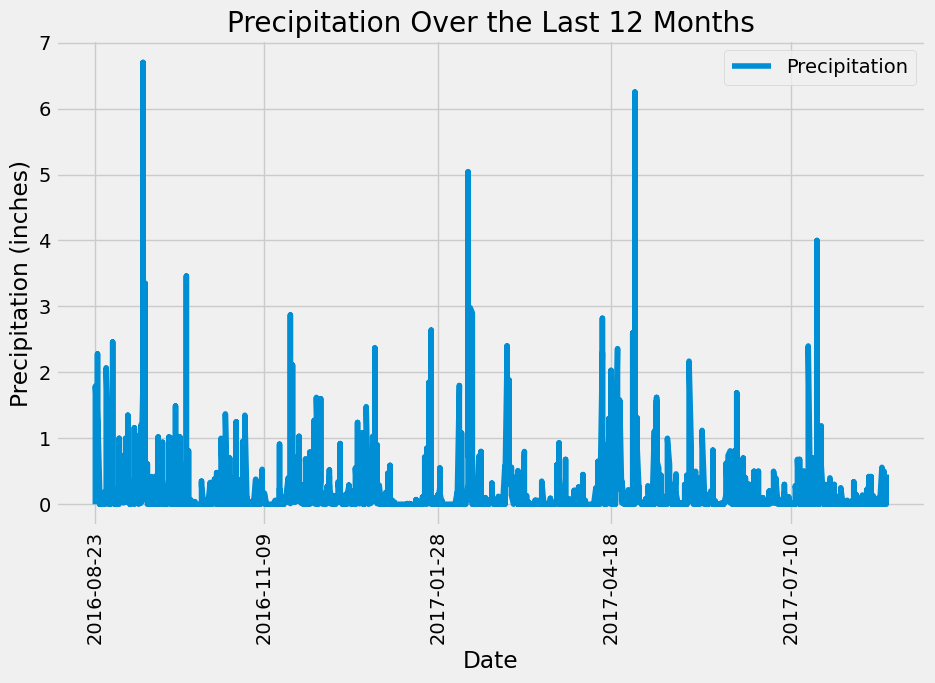

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
most_recent_date = pd.to_datetime("2017-08-23")

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Convert the date one year ago to a string format
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df = precipitation_df.dropna()


# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values('Date')


# Use Pandas Plotting with Matplotlib to plot the data

#List the necessary dates
xticks_dates = [
    pd.to_datetime("2016-08-23"),
    pd.to_datetime("2016-11-09"),
    pd.to_datetime("2017-01-28"),
    pd.to_datetime("2017-04-18"),
    pd.to_datetime("2017-07-10")
]
xticks_labels = [date.strftime('%Y-%m-%d') for date in xticks_dates]

plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], linestyle='-', label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over the Last 12 Months')

# Set custom x-ticks
plt.xticks(ticks=xticks_dates, labels=xticks_labels, rotation=90)

plt.legend()

# Show the plot
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
summary_stats = pd.DataFrame(summary_stats)
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Station.station).distinct().count()
number_of_stations

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations_query = session.query(
    Measurement.station,
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations_df = pd.DataFrame(active_stations_query, columns=['Station', 'Count'])
active_stations_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations_df.iloc[0]['Station']

temperature_data = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station).one()

print(f"Station ID: {most_active_station}")
print(f"Lowest Temperature: {temperature_data.min_temp:.2f}")
print(f"Highest Temperature: {temperature_data.max_temp:.2f}")
print(f"Average Temperature: {temperature_data.avg_temp:.2f}")


Station ID: USC00519281
Lowest Temperature: 54.00
Highest Temperature: 85.00
Average Temperature: 71.66


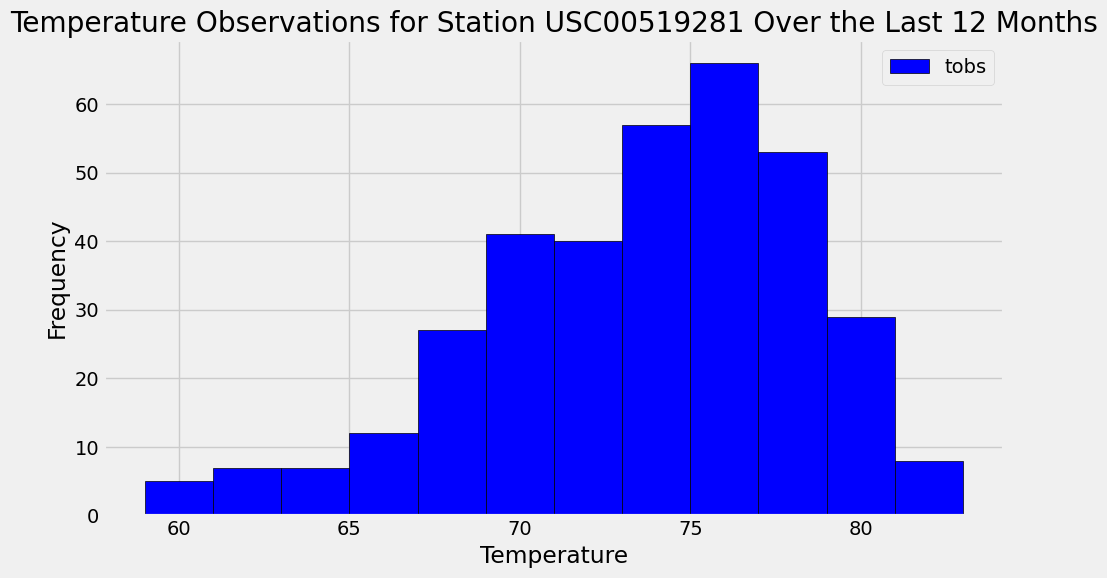

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago_str).\
    all()

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='blue', edgecolor='black', label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station} Over the Last 12 Months')

#Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()